In [2]:
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader

# Read dataset

In [16]:
import pickle as pkl
import json
import ast
np.set_printoptions(threshold=np.inf)
"""
param:path of folder
return :data_train_X,data_train_Y,data_validation_X,data_validation_Y,data_test_X,data_test_Y
"""
def load_data(path = "DataSet/"):
    path_set = os.listdir(path)
    dataSet = []
    for filename in path_set:
        #read features of constraints 
        cons_file = open(path+filename+"/constraints_features.json","rb")
        data = json.load(cons_file)
        data_cons = np.array(data["values"])
        nb_cons = data_cons.shape[0]
        #read features of variables 
        var_file = open(path+filename+"/variables_features.json","rb")
        data = json.load(var_file)
        data_var = np.array(data["values"])
        nb_var = data_var.shape[0]
        #compose H
        data_cons = np.hstack((np.zeros((data_cons.shape[0],19)),data_cons))
        data_var = np.hstack((data_var,np.zeros((data_var.shape[0],5))))
        matrix_H = np.vstack((data_var,data_cons))
        
        #read label 
        label_file = open(path+filename+"/label.json","rb")
        data = json.load(label_file)
        bestSol = data["Best_Solution"]
        data_label = np.array(bestSol)

        #read edge
        edges_file = open(path+filename+"/edges_features.json","rb")
        data = json.load(edges_file)
        matrix_A = np.zeros((nb_cons+nb_var,nb_cons+nb_var))
        for i in range(len(data["values"])):
            iVar,iCons = data["indices"][1][i],data["indices"][0][i] 
            matrix_A[iVar][nb_var+iCons] = data["values"][i]
            matrix_A[iCons+nb_var][iVar] = data["values"][i]
        
        dataSet.append({"X":matrix_H,"Y":data_label,"A":matrix_A})
        
    return np.array(dataSet)
split = [0.70,0.15,0.15]
dataSet = load_data()
data_train,data_validation,data_test = torch.utils.data.random_split(dataSet,[int(len(dataSet) * s) for s in split])
# print(dataSet[0]['A'])
# for l in dataSet[0]['A']:
#     for i in l:
#         print(int(i!=0),end = '\t')
#     print()

# data_train_X,data_train_Y,data_validation_X,data_validation_Y,data_test_X,data_test_Y,A = load_data()
# print(data_train_X.shape)
# print(data_train_Y.shape)
# print(A.shape)
print(data_train[0])

{'X': array([[ 1.00000000e+000,  0.00000000e+000,  0.00000000e+000,
         0.00000000e+000,  1.00000000e+000,  1.00000000e+000,
         1.24007110e-001, -0.00000000e+000, -0.00000000e+000,
         1.00000000e+000,  0.00000000e+000,  9.09090909e-002,
         0.00000000e+000,  1.20105990e-004,  1.00000000e+000,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
         4.64174843e-310,  0.00000000e+000,  0.00000000e+000,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000],
       [ 1.00000000e+000,  0.00000000e+000,  0.00000000e+000,
         0.00000000e+000,  1.00000000e+000,  1.00000000e+000,
        -0.00000000e+000,  5.00000000e-001,  5.00000000e-001,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
         1.00000000e+000,  9.99219311e-001,  0.00000000e+000,
         1.00000000e+000,  0.00000000e+000,  0.00000000e+000,
         4.64174883e-310,  0.00000000e+000,  0.00000000e+000,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000],


# GCN






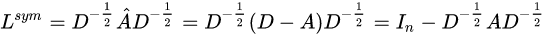

In [139]:
class MLP(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(MLP, self).__init__()
        self.linear = nn.Linear(in_channel, out_channel)
        self.activate = nn.ReLU()
        
    def forward(self, x, A):
        print("x before l",x[0][0])
        x = self.linear(x)
        
        print("x after l",x[0][0])
#         print("A",A[0])

        x = self.activate(x)
#         print("xact",x[0])
        x = A.mm(x)       
#         print("xmm",x[0])
        return x
    
class Net(nn.Module):
    def __init__(self, in_channel,aux_channel,out_channel):
        super(Net,self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(aux_channel, aux_channel),
            nn.ReLU(),
            nn.Linear(aux_channel, aux_channel),
        )
        self.mlp = MLP(in_channel, aux_channel)
        self.outlayer = nn.Sequential(
            nn.Linear(aux_channel, aux_channel),
            nn.ReLU(),
            nn.Linear(aux_channel, out_channel),
            nn.LogSoftmax()
#             nn.Sigmoid()
        )
    
    def forward(self, x, A,nb_net):
        x = self.mlp(x,A)
        for i in range(nb_net):
            x = self.layer(x)
        x = self.outlayer(x)
        return x

    

## Train


In [140]:
def train(model, x, y,A, optimizer,nb_net,criterion):
    model.zero_grad()
    size_y = len(y)
    output = model(x.float(),A.float(),nb_net)[:100].squeeze(dim=-1)
    print("output",output)
    loss =criterion(output,y)
    print("loss",loss)
    loss.backward()
    optimizer.step()

    return loss, output

In [145]:
device = torch.device("cpu")#"cuda:0" if torch.cuda.is_available() else "cpu")

net = Net(24,50,1)
nb_net = 1
EPOCHS = 2
optm = Adam(net.parameters(), lr = 0.001)
criterion = nn.BCEWithLogitsLoss()

for epoch in range(EPOCHS):
    epoch_loss = 0
    correct = 0
    for i in tqdm(range(len(data_train))):
        x_train, y_train = torch.from_numpy(data_train[i]['X']),torch.from_numpy(data_train[i]['Y']).type(torch.FloatTensor)
        A = torch.from_numpy(data_train[i]['A'])
        x_train = x_train.to(device)
        y_train = y_train.to(device)
        loss, predictions = train(net,x_train,y_train,A,optm,nb_net, criterion)


 19%|███████████████                                                                  | 13/70 [00:00<00:00, 124.01it/s]

tensor([[1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0909],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0909],
        [0.0000, 0.0000, 0.0000,  ..., 1.0000, 0.0000, 0.0909]],
       dtype=torch.float64) tensor([1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
        0., 0., 1., 1., 0., 0., 0., 1., 0., 1.])
x before l tensor(1.)
x after l tensor(-0.4785, grad_fn=<SelectBackward>)
output tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 

 57%|██████████████████████████████████████████████▎                                  | 40/70 [00:00<00:00, 126.65it/s]

 tensor([0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
x before l tensor(1.)
x after l tensor(nan, grad_fn=<SelectBackward>)
output tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, n

  0%|                                                                                           | 0/70 [00:00<?, ?it/s]

 tensor([0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 1., 0., 0., 0., 0., 0.])
x before l tensor(1.)
x after l tensor(nan, grad_fn=<SelectBackward>)
output tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, n

 46%|█████████████████████████████████████                                            | 32/70 [00:00<00:00, 153.07it/s]

output tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan], grad_fn=<SqueezeBackward1>)
loss tensor(nan, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor([[ 1.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 1.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 1.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0769],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.076

 67%|██████████████████████████████████████████████████████▍                          | 47/70 [00:00<00:00, 149.09it/s]

tensor([[ 1.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 1.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 1.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  1.0000, -0.0020,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0833],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0833]],
       dtype=torch.float64) tensor([0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1.,
        1., 1., 0., 0., 0., 1., 1., 0., 0., 0.])
x before l tensor(1.)
x after l tensor(nan, grad_fn=<SelectBackward>)
output tensor([nan,

100%|█████████████████████████████████████████████████████████████████████████████████| 70/70 [00:00<00:00, 146.53it/s]

tensor(nan, grad_fn=<SelectBackward>)
output tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan], grad_fn=<SqueezeBackward1>)
loss tensor(nan, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor([[1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0714],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.000

In [142]:
# for parameters in net.parameters():
#     print(parameters)